In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D, Activation
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/TrainData/TrainAnnotations.csv', dtype = 'str')
df['annotation'].value_counts()

0    488
1    329
4    197
3    131
2    130
Name: annotation, dtype: int64

In [ ]:
batch_size = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True, fill_mode ='nearest', )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(directory =  '/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/Train',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical', 
                                                    target_size = (224, 224))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( directory = '/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical', 
                                                          target_size = (224, 224))

Found 956 images belonging to 5 classes.
Found 318 images belonging to 5 classes.


In [ ]:
from keras.applications import vgg16
from keras.applications.densenet import DenseNet121
base_model = DenseNet121(input_shape=(224, 224, 3), weights='imagenet',include_top = False, pooling = 'avg')




In [ ]:
len(base_model.layers)

428

In [ ]:
for layer in base_model.layers[:360]:
  layer.trainable = False

for layer in base_model.layers[360:]:
  layer.trainable = True

x = base_model.output
x = Dense(1000)(x)

x = Activation('relu')(x)
x = Dense(500)(x)

x = Activation('relu')(x)
predictions = Dense(5, activation='softmax')(x)
densenet_model = Model(inputs=base_model.input, outputs=predictions)
densenet_model.compile(loss = "categorical_crossentropy", optimizer = 'Adam' , metrics = ['accuracy'])

densenet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

def get_callbacks():

   path_checkpoint ='checkpoint_keras'  
   log_dir='logs'
   
   callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                         monitor='val_loss',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         period=1)
   
   callback_early_stopping = EarlyStopping(monitor='val_loss',
                                           patience=5,
                                           verbose=1)
   
   callback_tensorboard = TensorBoard(log_dir=log_dir,
                                      histogram_freq=0,
                                      write_graph=False)
   
   callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          min_lr=1e-4,
                                          patience=3,
                                          verbose=1)

   callbacks = [callback_checkpoint, callback_tensorboard, callback_reduce_lr]

   return callbacks

In [ ]:
epochs = 30

In [ ]:
densenet_model.fit_generator(train_generator, 
                    epochs = epochs, 
                    validation_data = validation_generator, callbacks = get_callbacks())



Epoch 1/30
 3/30 [==>...........................] - ETA: 2:22 - loss: 2.2521 - accuracy: 0.2917

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (1.202400). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


30/30 [==============================] - 34s 1s/step - loss: 1.1799 - accuracy: 0.5921 - val_loss: 2.2810 - val_accuracy: 0.4308

Epoch 00001: val_loss improved from -inf to 2.28098, saving model to checkpoint_keras
Epoch 2/30
30/30 [==============================] - 19s 618ms/step - loss: 0.6969 - accuracy: 0.7218 - val_loss: 1.6677 - val_accuracy: 0.5094

Epoch 00002: val_loss did not improve from 2.28098
Epoch 3/30
30/30 [==============================] - 22s 730ms/step - loss: 0.5453 - accuracy: 0.7824 - val_loss: 4.2510 - val_accuracy: 0.2453

Epoch 00003: val_loss improved from 2.28098 to 4.25098, saving model to checkpoint_keras
Epoch 4/30
30/30 [==============================] - 21s 706ms/step - loss: 0.4906 - accuracy: 0.7981 - val_loss: 3.3935 - val_accuracy: 0.2704

Epoch 00004: val_loss did not improve from 4.25098
Epoch 5/30
30/30 [==============================] - 22s 733ms/step - loss: 0.4303 - accuracy: 0.8305 - val_loss: 2.5611 - val_accuracy: 0.3522

Epoch 00005: val_

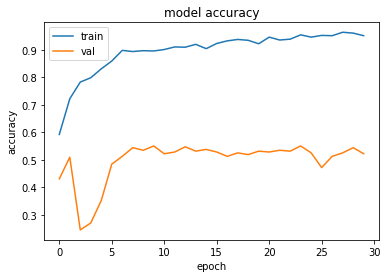

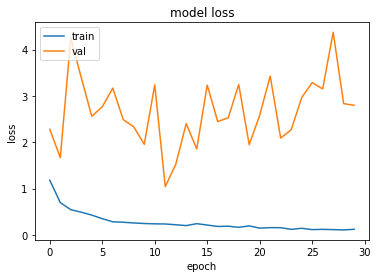

In [ ]:
history = densenet_model.history

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/accuracy_curve.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/loss_curve.png')

In [ ]:
import numpy
import sklearn.metrics as metrics
img_width, img_height = 224, 224
batch_size = 8
epochs = 100
test_set_dir = "/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/TestData"

num_test = len(os.listdir(test_set_dir))
num_test

1

In [ ]:
#Save the model
densenet_model.save('/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/dense_net_model.h5')
with open('/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/densenet_model.json', 'w') as f:
    f.write(densenet_model.to_json())

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        directory = r"/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/TestData",
        target_size=(224, 224),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
print(filenames)

Found 200 images belonging to 1 classes.
['0/020031.jpg', '0/020244.jpg', '0/020446.jpg', '0/020597.jpg', '0/020693.jpg', '0/020720.jpg', '0/020783.jpg', '0/020795.jpg', '0/020810.jpg', '0/020833.jpg', '0/020835.jpg', '0/020848.jpg', '0/020861.jpg', '0/020877.jpg', '0/020881.jpg', '0/020963.jpg', '0/020980.jpg', '0/021039.jpg', '0/021048.jpg', '0/021095.jpg', '0/021104.jpg', '0/021220.jpg', '0/021267.jpg', '0/021366.jpg', '0/021423.jpg', '0/021455.jpg', '0/021457.jpg', '0/021621.jpg', '0/021659.jpg', '0/021729.jpg', '0/021763.jpg', '0/021773.jpg', '0/021818.jpg', '0/021819.jpg', '0/022010.jpg', '0/022021.jpg', '0/022090.jpg', '0/022127.jpg', '0/022145.jpg', '0/022158.jpg', '0/022202.jpg', '0/022231.jpg', '0/022377.jpg', '0/022385.jpg', '0/022432.jpg', '0/022438.jpg', '0/022497.jpg', '0/022551.jpg', '0/022554.jpg', '0/022628.jpg', '0/022629.jpg', '0/022642.jpg', '0/022757.jpg', '0/022800.jpg', '0/022826.jpg', '0/023041.jpg', '0/023112.jpg', '0/023195.jpg', '0/023229.jpg', '0/023278.jpg'

In [ ]:
import numpy as np
# #load model

new_model = keras.models.load_model('/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/dense_net_model.h5')
print("Model loaded successfully")

Model loaded successfully


In [ ]:
predictions = new_model.predict_generator(test_generator) 
print(predictions)    
predictions = np.argmax(predictions, axis=-1) #multiple categories
label = (test_generator.class_indices)
print(predictions)

[[1.00484776e-05 9.99986291e-01 2.35432935e-06 2.90336999e-07
  1.04647927e-06]
 [4.42042375e-10 6.86411295e-06 3.87214660e-09 3.97830604e-07
  9.99992728e-01]
 [9.05481645e-09 1.94493623e-05 8.41104679e-08 1.38804917e-05
  9.99966621e-01]
 [1.37088060e-01 8.62818658e-01 9.04257104e-05 1.29268346e-06
  1.58575733e-06]
 [5.23727728e-10 9.99999404e-01 7.36757011e-09 7.09104153e-09
  6.14107194e-07]
 [8.28180902e-08 4.99409634e-06 1.18270930e-06 1.82460574e-03
  9.98169065e-01]
 [5.44114476e-11 9.99998689e-01 6.51952448e-09 1.06574412e-08
  1.28043200e-06]
 [1.34141196e-03 9.98657942e-01 5.12783572e-07 1.41474068e-08
  6.31240908e-08]
 [6.18103613e-08 9.99998808e-01 7.97551607e-08 3.57449927e-08
  9.07166054e-07]
 [1.16659803e-05 9.99988317e-01 1.04231903e-08 2.36934611e-10
  1.21088539e-09]
 [5.73562708e-09 9.99997616e-01 8.31658383e-07 3.14464586e-07
  1.13280510e-06]
 [1.97892115e-12 8.39204901e-08 3.11559251e-11 1.18193162e-08
  9.99999881e-01]
 [5.42533041e-09 1.50849507e-03 9.551769

In [ ]:
test_set_dir = os.path.join('/content/drive/My Drive/Projects/Neural_Network_Competition_Project/Phase_2/TestData/0')
test_names = os.listdir(test_set_dir )
print("Test data has: ", len(test_names) , " images." )
print(test_names[:10])
image_prediction_dict = {}
for x, y in zip(test_names,predictions):
  image_prediction_dict[x] = y
  
class0 = [k for k,v in image_prediction_dict.items() if v == 0]
class1 = [k for k,v in image_prediction_dict.items() if v == 1]
class2 = [k for k,v in image_prediction_dict.items() if v == 2]
class3 = [k for k,v in image_prediction_dict.items() if v == 3]
class4 = [k for k,v in image_prediction_dict.items() if v == 4]
print("\nClass 0 images: ", len(class0), "\nClass 1 images: ", len(class1), "\nClass 2 images: ", len(class2), "\nClass 3 images: " ,len(class3), "\nClass 4 images: ", len(class4))
print(image_prediction_dict)

Test data has:  200  images.
['024774.jpg', '024801.jpg', '024888.jpg', '024768.jpg', '023780.jpg', '024535.jpg', '024606.jpg', '024689.jpg', '023674.jpg', '025179.jpg']

Class 0 images:  9 
Class 1 images:  136 
Class 2 images:  0 
Class 3 images:  0 
Class 4 images:  55
{'024774.jpg': 1, '024801.jpg': 4, '024888.jpg': 4, '024768.jpg': 1, '023780.jpg': 1, '024535.jpg': 4, '024606.jpg': 1, '024689.jpg': 1, '023674.jpg': 1, '025179.jpg': 1, '025146.jpg': 1, '023542.jpg': 4, '022629.jpg': 4, '022554.jpg': 1, '022551.jpg': 1, '023474.jpg': 1, '024060.jpg': 1, '022432.jpg': 1, '022438.jpg': 1, '023304.jpg': 1, '023330.jpg': 1, '023369.jpg': 1, '023370.jpg': 0, '022385.jpg': 1, '023229.jpg': 1, '023897.jpg': 1, '023278.jpg': 4, '023846.jpg': 1, '023291.jpg': 1, '023822.jpg': 1, '022377.jpg': 4, '022158.jpg': 0, '022202.jpg': 4, '022231.jpg': 1, '023112.jpg': 1, '021366.jpg': 4, '022127.jpg': 4, '022145.jpg': 1, '022090.jpg': 1, '023041.jpg': 1, '023195.jpg': 1, '022826.jpg': 4, '021267.jpg'